In [4]:
# Basic Imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
import json
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import scipy
import matplotlib.pyplot as plt


# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

wandb_dir = os.path.join(os.path.expanduser('~'), "PFGMPP")
os.environ["WANDB_DIR"] = os.path.abspath(wandb_dir)

# Goal

The goal for this notebook was to double check Davids intuition about how the integral of a gaussian likelihood from $-\infty$ to $x$ would be uniformly sampled. We do this because we want to see if the ODE formulation for SBGM in this [JAX colab notebook](https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing), which allows for exact likelihood computation, is correct. We want to do this because there is no visualization of the outputs of the likelihood computation in the colab notebook. It also assumes the conditional probability distributions would be Gaussian (**READ THE PAPER FOR THIS TO CONFIRM**), so doing this basic test would be useful test.

To do this we:
1. Sample from a Gaussian distribution
2. Calculate the (Gaussian) likelihood for these gaussian sampled random variables
3. Calculate the integral of the likelihood from negative infinity to the rv of choice: $CDF(x) = \int_{-\infty}^x LL(x) dx$
4. Plot the histogram $CDF(x)$ and see that it's uniformly distributed.

If it's uniformly distributed then we know that the samples actually came from (Gaussian) LL.

**NOTE:** Read Kevin Murphy's Notes on [Gaussians](https://www.ics.uci.edu/~smyth/courses/cs274/readings/Murphy_multivariate_gaussians.pdf), as well as, [Chapter 6.5](https://mml-book.github.io/book/mml-book.pdf) of the Mathematics for Machine Learning book for understanding the CDF of gaussians.

In [7]:
def plot_likelihoods(mu=1, sigma=2, n=100000, seed=123):

    rng = np.random.RandomState(123)
    # Generate samples from a normal distribution.
    x = rng.normal(loc=mu, scale=sigma, size=n)
    # The likelihood of x is
    L = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    # Calculate the integral of L from -inf to x
    C = 0.5 * scipy.special.erfc((mu - x)/(np.sqrt(2)*sigma))
    # Check that values of C have a uniform Distribution
    plt.hist(C, bins=50)

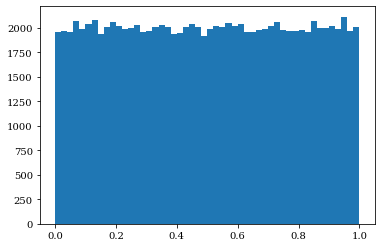

In [8]:
plot_likelihoods()

Now let's try for some outliers

In [13]:
def plot_likelihoods_outliers(mu=1, sigma=2, n=100000, seed=123):

    rng = np.random.RandomState(123)
    # Generate samples from a normal distribution.
    x = rng.normal(loc=mu, scale=sigma, size=n)
    # Generate outlier samples from a multimodal distribution
    outliers_x1 = rng.normal(loc=-4, scale=1.5, size=int(n//2))
    outliers_x2 = rng.normal(loc=4, scale=0.4, size=int(n//2))
    outliers = np.concatenate([outliers_x1, outliers_x2])
    
    # The likelihood of x is
    L = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    # The likelihood of outliers is
    L_out = np.exp(-0.5 * ((outliers - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    
    # Calculate the integral of L from -inf to x
    C = 0.5 * scipy.special.erfc((mu - x)/(np.sqrt(2)*sigma))
    # Calculate the integral of L from -inf to x
    C_out = 0.5 * scipy.special.erfc((mu - outliers)/(np.sqrt(2)*sigma))
    
    plt.hist(C, bins=50, alpha=0.5, label='True data') # Check that values of C have a uniform Distribution
    plt.hist(C_out, bins=50, alpha=0.5, label='Outliers') # Check that values of C_out do not have a uniform Distribution
    plt.legend()

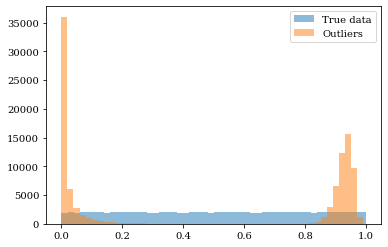

In [14]:
plot_likelihoods_outliers()

As we see. Samples that are from a Gaussian have a Uniform CDF, while samples that are from a non-Gaussian distribution have a peaked distribution. **Why?**

# LL

## Goal

The goal for this notebook was to double check Davids intuition about how likelihoods would be distributed uniformly. To do this we use a simple normal distribution. We sample from said distribution, calculated the LL of those samples being from a normal distribution, and plot the resulting likelihoods.

The reason we do this test is because using the ODE formulation for SBGM allows one to do exact likelihood computation and in the [JAX colab notebook](https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing) of Yang Song they don't visualize the LL distribution, but rather just calculate it for a batch of samples. Because of this lack of visualization David wanted to make sure the LL computation was correct and the way to do that (**he thinks**), is to see if the likelihoods are normally distributed.

In [ ]:
# Generate some data from a normal distribution
xs = np.random.normal(size=(10000,))

# Function to compute the Gaussian likelihood
def gauss_LL(x):
    LL = (1 / np.sqrt(2*np.pi)) * np.exp(-x**2 / 2)
    return LL

# Compute the likelihoods
likelihoods = gauss_LL(xs)
# likelihoods = norm.pdf(xs, loc=0, scale=1)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of the data on the first subplot
axes[0].hist(xs, bins=100)
axes[0].set_title("Histogram of the data")
axes[1].hist(likelihoods, bins=100)
axes[1].set_title("Histogram of Likelihoods")

# Show both plots
plt.tight_layout()
plt.show()

## Main Results

We see that the distribution of likelihoods are **NOT** uniformly distributed, but rather has a large peak of values of $\sim 0.40$. 

**Why is this the case?**
- It is due to the fact that the likelihoods will be higher for points closer to the mean ($0$ in this case), since the points are more "likely" under a Gaussian distribution centered around the mean.
    - Note that the value of $0.40$ is in fact the LL of 0 i.e.:
      $$f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \text{exp}(-\frac{(x-\mu)^2}{2\sigma^2}) $$
      $$f(x | \mu=0, \sigma^2=1) = \frac{1}{\sqrt{2\pi}} \text{exp}(-\frac{(x-0)^2}{2}) $$
      $$f(x=0 | 0, 1) = \frac{1}{\sqrt{2\pi}} \text{exp}(0) = \frac{1}{\sqrt{2\pi}} \approx 0.40$$
- The likelihoods of samples from a Gaussian distribution will themselves follow a distribution that reflects the shape of the original Gaussian distribution, peaked around the mean.


## Outlier testing

In [ ]:
samples1 = np.random.normal(-4, 1.5, size=(5000,))
samples2 = np.random.normal(4, 0.7, size=(5000,))
outlier_arr = np.concatenate([samples1, samples2])

outlier_LL = gauss_LL(outlier_arr)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram of the data on the first subplot
axes[0].hist(outlier_arr, alpha=0.5, bins=100, label='Outliers')
axes[0].hist(xs, alpha=0.5, bins=100, label='True Data')
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Data")
axes[0].legend()

axes[1].hist(outlier_LL, bins=100, alpha=0.5, label='Outlier LL')
axes[1].hist(likelihoods, bins=100, alpha=0.5, label='True Data LL')
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of outlier Likelihoods")
axes[1].legend()

# Show both plots
plt.tight_layout()
plt.show()

**Results:**
- See that our mixture model has very low probability (see the large blue peak centered at 0 on the right plot). Which makes sense because there is very little overlap between the original Gaussian distribution (orange) and the mixture models samples (in blue).